In [116]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff

In [117]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [118]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
#pls_par = np.array([-580., 10., -10., 40., 120., 15.]) 
pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,20)
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,20)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [119]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 4.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)



#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


In [120]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [121]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [122]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [123]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [124]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [125]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [149]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad

In [150]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [151]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-480. -100.  -80.   20.   50.   25.]
[-479.62134089 -105.63435967  -77.65042818   10.           51.47050136
   21.68967987]


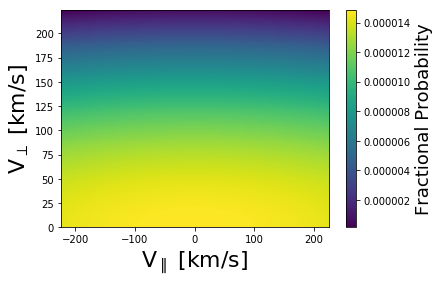

In [169]:
#create grid to call predictions
#pred_grid = np.zeros(dis_vdf_bad_guess['pgrid'].shape)+1
#change initial prediction to be based on the log of the input VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [153]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.

In [174]:

kernel = 20./np.sqrt(2.)

start_loop = time.time()
#removed to test improving fit
for i in range(1000):
    #error from previous iteration
    pre_err = per_err
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,
                                                                            dis_vdf_bad,cont,
                                                                            pred_grid,kernel,
                                                                            improved=improved,ip=ip,
                                                                            iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=per_err,samp=samp)
    
    if improved:
        #scale probability by how large of a jump is made
        if tot_err > 1e30:
            scale = 0.1
        else:
            scale = (pre_err-tot_err)
            if scale < 0.:
                scale = 0.
        
        #calculate peak at ip,iq values
        a = 1000.*(scale)/float(pred_grid.size)
        #create new probability grid with a Gaussian Kernel Added at the new point
        pred_grid += a*np.exp(- ((dis_vdf_bad_guess['pgrid']-ip)/(kernel))**2./2.
                              - ((dis_vdf_bad_guess['qgrid']-iq)/(kernel))**2./2.)
        #normalize to 1
        pred_grid /= np.sum(pred_grid)
         
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))

end_loop = time.time()
print('Loop time {0:1.1f}'.format(end_loop-start_loop))

Total error for iteration 0 is 5.998e+00%
Total error for iteration 1 is 5.998e+00%
Total error for iteration 2 is 5.998e+00%
Total error for iteration 3 is 5.998e+00%
Total error for iteration 4 is 5.973e+00%
Total error for iteration 5 is 5.973e+00%
Total error for iteration 6 is 5.973e+00%
Total error for iteration 7 is 5.973e+00%
Total error for iteration 8 is 5.973e+00%
Total error for iteration 9 is 5.973e+00%
Total error for iteration 10 is 5.973e+00%
Total error for iteration 11 is 5.973e+00%
Total error for iteration 12 is 5.972e+00%
Total error for iteration 13 is 5.972e+00%
Total error for iteration 14 is 5.972e+00%
Total error for iteration 15 is 5.972e+00%
Total error for iteration 16 is 5.972e+00%
Total error for iteration 17 is 5.972e+00%
Total error for iteration 18 is 5.965e+00%
Total error for iteration 19 is 5.960e+00%
Total error for iteration 20 is 5.958e+00%
Total error for iteration 21 is 5.958e+00%
Total error for iteration 22 is 5.958e+00%
Total error for itera

Total error for iteration 189 is 5.877e+00%
Total error for iteration 190 is 5.877e+00%
Total error for iteration 191 is 5.877e+00%
Total error for iteration 192 is 5.877e+00%
Total error for iteration 193 is 5.877e+00%
Total error for iteration 194 is 5.877e+00%
Total error for iteration 195 is 5.877e+00%
Total error for iteration 196 is 5.877e+00%
Total error for iteration 197 is 5.877e+00%
Total error for iteration 198 is 5.877e+00%
Total error for iteration 199 is 5.877e+00%
Total error for iteration 200 is 5.877e+00%
Total error for iteration 201 is 5.876e+00%
Total error for iteration 202 is 5.876e+00%
Total error for iteration 203 is 5.876e+00%
Total error for iteration 204 is 5.876e+00%
Total error for iteration 205 is 5.876e+00%
Total error for iteration 206 is 5.876e+00%
Total error for iteration 207 is 5.876e+00%
Total error for iteration 208 is 5.876e+00%
Total error for iteration 209 is 5.876e+00%
Total error for iteration 210 is 5.876e+00%
Total error for iteration 211 is

Total error for iteration 376 is 5.812e+00%
Total error for iteration 377 is 5.812e+00%
Total error for iteration 378 is 5.812e+00%
Total error for iteration 379 is 5.812e+00%
Total error for iteration 380 is 5.812e+00%
Total error for iteration 381 is 5.812e+00%
Total error for iteration 382 is 5.812e+00%
Total error for iteration 383 is 5.812e+00%
Total error for iteration 384 is 5.812e+00%
Total error for iteration 385 is 5.812e+00%
Total error for iteration 386 is 5.812e+00%
Total error for iteration 387 is 5.812e+00%
Total error for iteration 388 is 5.812e+00%
Total error for iteration 389 is 5.812e+00%
Total error for iteration 390 is 5.812e+00%
Total error for iteration 391 is 5.809e+00%
Total error for iteration 392 is 5.809e+00%
Total error for iteration 393 is 5.809e+00%
Total error for iteration 394 is 5.809e+00%
Total error for iteration 395 is 5.809e+00%
Total error for iteration 396 is 5.809e+00%
Total error for iteration 397 is 5.809e+00%
Total error for iteration 398 is

Total error for iteration 563 is 5.787e+00%
Total error for iteration 564 is 5.787e+00%
Total error for iteration 565 is 5.787e+00%
Total error for iteration 566 is 5.787e+00%
Total error for iteration 567 is 5.786e+00%
Total error for iteration 568 is 5.786e+00%
Total error for iteration 569 is 5.786e+00%
Total error for iteration 570 is 5.786e+00%
Total error for iteration 571 is 5.786e+00%
Total error for iteration 572 is 5.786e+00%
Total error for iteration 573 is 5.786e+00%
Total error for iteration 574 is 5.786e+00%
Total error for iteration 575 is 5.786e+00%
Total error for iteration 576 is 5.786e+00%
Total error for iteration 577 is 5.786e+00%
Total error for iteration 578 is 5.786e+00%
Total error for iteration 579 is 5.786e+00%
Total error for iteration 580 is 5.786e+00%
Total error for iteration 581 is 5.786e+00%
Total error for iteration 582 is 5.786e+00%
Total error for iteration 583 is 5.786e+00%
Total error for iteration 584 is 5.786e+00%
Total error for iteration 585 is

Total error for iteration 750 is 5.783e+00%
Total error for iteration 751 is 5.783e+00%
Total error for iteration 752 is 5.783e+00%
Total error for iteration 753 is 5.783e+00%
Total error for iteration 754 is 5.783e+00%
Total error for iteration 755 is 5.783e+00%
Total error for iteration 756 is 5.783e+00%
Total error for iteration 757 is 5.783e+00%
Total error for iteration 758 is 5.783e+00%
Total error for iteration 759 is 5.783e+00%
Total error for iteration 760 is 5.783e+00%
Total error for iteration 761 is 5.783e+00%
Total error for iteration 762 is 5.783e+00%
Total error for iteration 763 is 5.783e+00%
Total error for iteration 764 is 5.783e+00%
Total error for iteration 765 is 5.783e+00%
Total error for iteration 766 is 5.783e+00%
Total error for iteration 767 is 5.783e+00%
Total error for iteration 768 is 5.783e+00%
Total error for iteration 769 is 5.783e+00%
Total error for iteration 770 is 5.783e+00%
Total error for iteration 771 is 5.783e+00%
Total error for iteration 772 is

Total error for iteration 937 is 5.780e+00%
Total error for iteration 938 is 5.780e+00%
Total error for iteration 939 is 5.780e+00%
Total error for iteration 940 is 5.780e+00%
Total error for iteration 941 is 5.780e+00%
Total error for iteration 942 is 5.780e+00%
Total error for iteration 943 is 5.780e+00%
Total error for iteration 944 is 5.780e+00%
Total error for iteration 945 is 5.780e+00%
Total error for iteration 946 is 5.780e+00%
Total error for iteration 947 is 5.780e+00%
Total error for iteration 948 is 5.780e+00%
Total error for iteration 949 is 5.780e+00%
Total error for iteration 950 is 5.780e+00%
Total error for iteration 951 is 5.780e+00%
Total error for iteration 952 is 5.780e+00%
Total error for iteration 953 is 5.780e+00%
Total error for iteration 954 is 5.780e+00%
Total error for iteration 955 is 5.780e+00%
Total error for iteration 956 is 5.780e+00%
Total error for iteration 957 is 5.780e+00%
Total error for iteration 958 is 5.780e+00%
Total error for iteration 959 is

Total error for iteration 1121 is 5.762e+00%
Total error for iteration 1122 is 5.762e+00%
Total error for iteration 1123 is 5.762e+00%
Total error for iteration 1124 is 5.762e+00%
Total error for iteration 1125 is 5.762e+00%
Total error for iteration 1126 is 5.762e+00%
Total error for iteration 1127 is 5.762e+00%
Total error for iteration 1128 is 5.762e+00%
Total error for iteration 1129 is 5.762e+00%
Total error for iteration 1130 is 5.762e+00%
Total error for iteration 1131 is 5.761e+00%
Total error for iteration 1132 is 5.761e+00%
Total error for iteration 1133 is 5.761e+00%
Total error for iteration 1134 is 5.761e+00%
Total error for iteration 1135 is 5.761e+00%
Total error for iteration 1136 is 5.761e+00%
Total error for iteration 1137 is 5.761e+00%
Total error for iteration 1138 is 5.757e+00%
Total error for iteration 1139 is 5.757e+00%
Total error for iteration 1140 is 5.757e+00%
Total error for iteration 1141 is 5.757e+00%
Total error for iteration 1142 is 5.757e+00%
Total erro

Total error for iteration 1304 is 5.729e+00%
Total error for iteration 1305 is 5.726e+00%
Total error for iteration 1306 is 5.725e+00%
Total error for iteration 1307 is 5.725e+00%
Total error for iteration 1308 is 5.725e+00%
Total error for iteration 1309 is 5.725e+00%
Total error for iteration 1310 is 5.725e+00%
Total error for iteration 1311 is 5.725e+00%
Total error for iteration 1312 is 5.725e+00%
Total error for iteration 1313 is 5.725e+00%
Total error for iteration 1314 is 5.725e+00%
Total error for iteration 1315 is 5.725e+00%
Total error for iteration 1316 is 5.725e+00%
Total error for iteration 1317 is 5.725e+00%
Total error for iteration 1318 is 5.725e+00%
Total error for iteration 1319 is 5.725e+00%
Total error for iteration 1320 is 5.725e+00%
Total error for iteration 1321 is 5.725e+00%
Total error for iteration 1322 is 5.725e+00%
Total error for iteration 1323 is 5.725e+00%
Total error for iteration 1324 is 5.725e+00%
Total error for iteration 1325 is 5.725e+00%
Total erro

Total error for iteration 1487 is 5.723e+00%
Total error for iteration 1488 is 5.723e+00%
Total error for iteration 1489 is 5.723e+00%
Total error for iteration 1490 is 5.723e+00%
Total error for iteration 1491 is 5.723e+00%
Total error for iteration 1492 is 5.723e+00%
Total error for iteration 1493 is 5.723e+00%
Total error for iteration 1494 is 5.723e+00%
Total error for iteration 1495 is 5.723e+00%
Total error for iteration 1496 is 5.723e+00%
Total error for iteration 1497 is 5.723e+00%
Total error for iteration 1498 is 5.723e+00%
Total error for iteration 1499 is 5.723e+00%
Total error for iteration 1500 is 5.723e+00%
Total error for iteration 1501 is 5.723e+00%
Total error for iteration 1502 is 5.723e+00%
Total error for iteration 1503 is 5.723e+00%
Total error for iteration 1504 is 5.723e+00%
Total error for iteration 1505 is 5.723e+00%
Total error for iteration 1506 is 5.723e+00%
Total error for iteration 1507 is 5.723e+00%
Total error for iteration 1508 is 5.723e+00%
Total erro

Total error for iteration 1670 is 5.698e+00%
Total error for iteration 1671 is 5.698e+00%
Total error for iteration 1672 is 5.698e+00%
Total error for iteration 1673 is 5.698e+00%
Total error for iteration 1674 is 5.698e+00%
Total error for iteration 1675 is 5.697e+00%
Total error for iteration 1676 is 5.697e+00%
Total error for iteration 1677 is 5.697e+00%
Total error for iteration 1678 is 5.697e+00%
Total error for iteration 1679 is 5.697e+00%
Total error for iteration 1680 is 5.696e+00%
Total error for iteration 1681 is 5.696e+00%
Total error for iteration 1682 is 5.696e+00%
Total error for iteration 1683 is 5.696e+00%
Total error for iteration 1684 is 5.696e+00%
Total error for iteration 1685 is 5.696e+00%
Total error for iteration 1686 is 5.696e+00%
Total error for iteration 1687 is 5.696e+00%
Total error for iteration 1688 is 5.696e+00%
Total error for iteration 1689 is 5.696e+00%
Total error for iteration 1690 is 5.696e+00%
Total error for iteration 1691 is 5.696e+00%
Total erro

Total error for iteration 1853 is 5.687e+00%
Total error for iteration 1854 is 5.687e+00%
Total error for iteration 1855 is 5.687e+00%
Total error for iteration 1856 is 5.687e+00%
Total error for iteration 1857 is 5.687e+00%
Total error for iteration 1858 is 5.687e+00%
Total error for iteration 1859 is 5.687e+00%
Total error for iteration 1860 is 5.687e+00%
Total error for iteration 1861 is 5.687e+00%
Total error for iteration 1862 is 5.687e+00%
Total error for iteration 1863 is 5.687e+00%
Total error for iteration 1864 is 5.687e+00%
Total error for iteration 1865 is 5.686e+00%
Total error for iteration 1866 is 5.685e+00%
Total error for iteration 1867 is 5.683e+00%
Total error for iteration 1868 is 5.679e+00%
Total error for iteration 1869 is 5.678e+00%
Total error for iteration 1870 is 5.678e+00%
Total error for iteration 1871 is 5.678e+00%
Total error for iteration 1872 is 5.678e+00%
Total error for iteration 1873 is 5.678e+00%
Total error for iteration 1874 is 5.678e+00%
Total erro

Total error for iteration 2036 is 5.669e+00%
Total error for iteration 2037 is 5.669e+00%
Total error for iteration 2038 is 5.669e+00%
Total error for iteration 2039 is 5.669e+00%
Total error for iteration 2040 is 5.669e+00%
Total error for iteration 2041 is 5.669e+00%
Total error for iteration 2042 is 5.669e+00%
Total error for iteration 2043 is 5.669e+00%
Total error for iteration 2044 is 5.669e+00%
Total error for iteration 2045 is 5.669e+00%
Total error for iteration 2046 is 5.669e+00%
Total error for iteration 2047 is 5.669e+00%
Total error for iteration 2048 is 5.669e+00%
Total error for iteration 2049 is 5.669e+00%
Total error for iteration 2050 is 5.669e+00%
Total error for iteration 2051 is 5.669e+00%
Total error for iteration 2052 is 5.669e+00%
Total error for iteration 2053 is 5.669e+00%
Total error for iteration 2054 is 5.669e+00%
Total error for iteration 2055 is 5.669e+00%
Total error for iteration 2056 is 5.669e+00%
Total error for iteration 2057 is 5.669e+00%
Total erro

Total error for iteration 2219 is 5.665e+00%
Total error for iteration 2220 is 5.665e+00%
Total error for iteration 2221 is 5.665e+00%
Total error for iteration 2222 is 5.665e+00%
Total error for iteration 2223 is 5.665e+00%
Total error for iteration 2224 is 5.665e+00%
Total error for iteration 2225 is 5.665e+00%
Total error for iteration 2226 is 5.665e+00%
Total error for iteration 2227 is 5.665e+00%
Total error for iteration 2228 is 5.665e+00%
Total error for iteration 2229 is 5.665e+00%
Total error for iteration 2230 is 5.665e+00%
Total error for iteration 2231 is 5.665e+00%
Total error for iteration 2232 is 5.665e+00%
Total error for iteration 2233 is 5.665e+00%
Total error for iteration 2234 is 5.665e+00%
Total error for iteration 2235 is 5.665e+00%
Total error for iteration 2236 is 5.665e+00%
Total error for iteration 2237 is 5.665e+00%
Total error for iteration 2238 is 5.665e+00%
Total error for iteration 2239 is 5.665e+00%
Total error for iteration 2240 is 5.665e+00%
Total erro

Total error for iteration 2402 is 5.662e+00%
Total error for iteration 2403 is 5.662e+00%
Total error for iteration 2404 is 5.662e+00%
Total error for iteration 2405 is 5.662e+00%
Total error for iteration 2406 is 5.662e+00%
Total error for iteration 2407 is 5.662e+00%
Total error for iteration 2408 is 5.662e+00%
Total error for iteration 2409 is 5.662e+00%
Total error for iteration 2410 is 5.662e+00%
Total error for iteration 2411 is 5.662e+00%
Total error for iteration 2412 is 5.662e+00%
Total error for iteration 2413 is 5.662e+00%
Total error for iteration 2414 is 5.662e+00%
Total error for iteration 2415 is 5.662e+00%
Total error for iteration 2416 is 5.662e+00%
Total error for iteration 2417 is 5.662e+00%
Total error for iteration 2418 is 5.662e+00%
Total error for iteration 2419 is 5.662e+00%
Total error for iteration 2420 is 5.662e+00%
Total error for iteration 2421 is 5.662e+00%
Total error for iteration 2422 is 5.662e+00%
Total error for iteration 2423 is 5.662e+00%
Total erro

Total error for iteration 2585 is 5.652e+00%
Total error for iteration 2586 is 5.652e+00%
Total error for iteration 2587 is 5.652e+00%
Total error for iteration 2588 is 5.652e+00%
Total error for iteration 2589 is 5.652e+00%
Total error for iteration 2590 is 5.652e+00%
Total error for iteration 2591 is 5.652e+00%
Total error for iteration 2592 is 5.652e+00%
Total error for iteration 2593 is 5.652e+00%
Total error for iteration 2594 is 5.652e+00%
Total error for iteration 2595 is 5.652e+00%
Total error for iteration 2596 is 5.652e+00%
Total error for iteration 2597 is 5.652e+00%
Total error for iteration 2598 is 5.652e+00%
Total error for iteration 2599 is 5.652e+00%
Total error for iteration 2600 is 5.652e+00%
Total error for iteration 2601 is 5.652e+00%
Total error for iteration 2602 is 5.652e+00%
Total error for iteration 2603 is 5.652e+00%
Total error for iteration 2604 is 5.652e+00%
Total error for iteration 2605 is 5.652e+00%
Total error for iteration 2606 is 5.652e+00%
Total erro

Total error for iteration 2768 is 5.652e+00%
Total error for iteration 2769 is 5.652e+00%
Total error for iteration 2770 is 5.652e+00%
Total error for iteration 2771 is 5.652e+00%
Total error for iteration 2772 is 5.652e+00%
Total error for iteration 2773 is 5.652e+00%
Total error for iteration 2774 is 5.652e+00%
Total error for iteration 2775 is 5.652e+00%
Total error for iteration 2776 is 5.652e+00%
Total error for iteration 2777 is 5.652e+00%
Total error for iteration 2778 is 5.652e+00%
Total error for iteration 2779 is 5.652e+00%
Total error for iteration 2780 is 5.652e+00%
Total error for iteration 2781 is 5.652e+00%
Total error for iteration 2782 is 5.652e+00%
Total error for iteration 2783 is 5.652e+00%
Total error for iteration 2784 is 5.652e+00%
Total error for iteration 2785 is 5.651e+00%
Total error for iteration 2786 is 5.651e+00%
Total error for iteration 2787 is 5.651e+00%
Total error for iteration 2788 is 5.651e+00%
Total error for iteration 2789 is 5.651e+00%
Total erro

Total error for iteration 2951 is 5.644e+00%
Total error for iteration 2952 is 5.644e+00%
Total error for iteration 2953 is 5.644e+00%
Total error for iteration 2954 is 5.644e+00%
Total error for iteration 2955 is 5.644e+00%
Total error for iteration 2956 is 5.644e+00%
Total error for iteration 2957 is 5.644e+00%
Total error for iteration 2958 is 5.644e+00%
Total error for iteration 2959 is 5.644e+00%
Total error for iteration 2960 is 5.644e+00%
Total error for iteration 2961 is 5.644e+00%
Total error for iteration 2962 is 5.644e+00%
Total error for iteration 2963 is 5.644e+00%
Total error for iteration 2964 is 5.644e+00%
Total error for iteration 2965 is 5.644e+00%
Total error for iteration 2966 is 5.644e+00%
Total error for iteration 2967 is 5.644e+00%
Total error for iteration 2968 is 5.644e+00%
Total error for iteration 2969 is 5.644e+00%
Total error for iteration 2970 is 5.644e+00%
Total error for iteration 2971 is 5.644e+00%
Total error for iteration 2972 is 5.644e+00%
Total erro

Total error for iteration 3134 is 5.638e+00%
Total error for iteration 3135 is 5.638e+00%
Total error for iteration 3136 is 5.638e+00%
Total error for iteration 3137 is 5.638e+00%
Total error for iteration 3138 is 5.638e+00%
Total error for iteration 3139 is 5.638e+00%
Total error for iteration 3140 is 5.638e+00%
Total error for iteration 3141 is 5.638e+00%
Total error for iteration 3142 is 5.637e+00%
Total error for iteration 3143 is 5.637e+00%
Total error for iteration 3144 is 5.637e+00%
Total error for iteration 3145 is 5.637e+00%
Total error for iteration 3146 is 5.637e+00%
Total error for iteration 3147 is 5.637e+00%
Total error for iteration 3148 is 5.637e+00%
Total error for iteration 3149 is 5.637e+00%
Total error for iteration 3150 is 5.637e+00%
Total error for iteration 3151 is 5.637e+00%
Total error for iteration 3152 is 5.637e+00%
Total error for iteration 3153 is 5.637e+00%
Total error for iteration 3154 is 5.637e+00%
Total error for iteration 3155 is 5.637e+00%
Total erro

Total error for iteration 3317 is 5.632e+00%
Total error for iteration 3318 is 5.632e+00%
Total error for iteration 3319 is 5.632e+00%
Total error for iteration 3320 is 5.632e+00%
Total error for iteration 3321 is 5.632e+00%
Total error for iteration 3322 is 5.632e+00%
Total error for iteration 3323 is 5.632e+00%
Total error for iteration 3324 is 5.632e+00%
Total error for iteration 3325 is 5.632e+00%
Total error for iteration 3326 is 5.632e+00%
Total error for iteration 3327 is 5.632e+00%
Total error for iteration 3328 is 5.632e+00%
Total error for iteration 3329 is 5.632e+00%
Total error for iteration 3330 is 5.632e+00%
Total error for iteration 3331 is 5.632e+00%
Total error for iteration 3332 is 5.632e+00%
Total error for iteration 3333 is 5.632e+00%
Total error for iteration 3334 is 5.632e+00%
Total error for iteration 3335 is 5.632e+00%
Total error for iteration 3336 is 5.632e+00%
Total error for iteration 3337 is 5.632e+00%
Total error for iteration 3338 is 5.632e+00%
Total erro

Total error for iteration 3500 is 5.629e+00%
Total error for iteration 3501 is 5.629e+00%
Total error for iteration 3502 is 5.629e+00%
Total error for iteration 3503 is 5.629e+00%
Total error for iteration 3504 is 5.629e+00%
Total error for iteration 3505 is 5.629e+00%
Total error for iteration 3506 is 5.629e+00%
Total error for iteration 3507 is 5.629e+00%
Total error for iteration 3508 is 5.629e+00%
Total error for iteration 3509 is 5.629e+00%
Total error for iteration 3510 is 5.629e+00%
Total error for iteration 3511 is 5.629e+00%
Total error for iteration 3512 is 5.629e+00%
Total error for iteration 3513 is 5.629e+00%
Total error for iteration 3514 is 5.629e+00%
Total error for iteration 3515 is 5.629e+00%
Total error for iteration 3516 is 5.629e+00%
Total error for iteration 3517 is 5.629e+00%
Total error for iteration 3518 is 5.629e+00%
Total error for iteration 3519 is 5.629e+00%
Total error for iteration 3520 is 5.629e+00%
Total error for iteration 3521 is 5.629e+00%
Total erro

Total error for iteration 3683 is 5.626e+00%
Total error for iteration 3684 is 5.626e+00%
Total error for iteration 3685 is 5.626e+00%
Total error for iteration 3686 is 5.626e+00%
Total error for iteration 3687 is 5.626e+00%
Total error for iteration 3688 is 5.626e+00%
Total error for iteration 3689 is 5.626e+00%
Total error for iteration 3690 is 5.626e+00%
Total error for iteration 3691 is 5.626e+00%
Total error for iteration 3692 is 5.626e+00%
Total error for iteration 3693 is 5.626e+00%
Total error for iteration 3694 is 5.626e+00%
Total error for iteration 3695 is 5.626e+00%
Total error for iteration 3696 is 5.626e+00%
Total error for iteration 3697 is 5.626e+00%
Total error for iteration 3698 is 5.626e+00%
Total error for iteration 3699 is 5.626e+00%
Total error for iteration 3700 is 5.626e+00%
Total error for iteration 3701 is 5.626e+00%
Total error for iteration 3702 is 5.626e+00%
Total error for iteration 3703 is 5.626e+00%
Total error for iteration 3704 is 5.626e+00%
Total erro

Total error for iteration 3866 is 5.593e+00%
Total error for iteration 3867 is 5.593e+00%
Total error for iteration 3868 is 5.593e+00%
Total error for iteration 3869 is 5.593e+00%
Total error for iteration 3870 is 5.593e+00%
Total error for iteration 3871 is 5.593e+00%
Total error for iteration 3872 is 5.593e+00%
Total error for iteration 3873 is 5.593e+00%
Total error for iteration 3874 is 5.593e+00%
Total error for iteration 3875 is 5.593e+00%
Total error for iteration 3876 is 5.593e+00%
Total error for iteration 3877 is 5.593e+00%
Total error for iteration 3878 is 5.593e+00%
Total error for iteration 3879 is 5.593e+00%
Total error for iteration 3880 is 5.593e+00%
Total error for iteration 3881 is 5.582e+00%
Total error for iteration 3882 is 5.582e+00%
Total error for iteration 3883 is 5.582e+00%
Total error for iteration 3884 is 5.582e+00%
Total error for iteration 3885 is 5.582e+00%
Total error for iteration 3886 is 5.582e+00%
Total error for iteration 3887 is 5.582e+00%
Total erro

Total error for iteration 4049 is 5.581e+00%
Total error for iteration 4050 is 5.581e+00%
Total error for iteration 4051 is 5.581e+00%
Total error for iteration 4052 is 5.581e+00%
Total error for iteration 4053 is 5.581e+00%
Total error for iteration 4054 is 5.581e+00%
Total error for iteration 4055 is 5.581e+00%
Total error for iteration 4056 is 5.581e+00%
Total error for iteration 4057 is 5.581e+00%
Total error for iteration 4058 is 5.581e+00%
Total error for iteration 4059 is 5.581e+00%
Total error for iteration 4060 is 5.581e+00%
Total error for iteration 4061 is 5.581e+00%
Total error for iteration 4062 is 5.581e+00%
Total error for iteration 4063 is 5.581e+00%
Total error for iteration 4064 is 5.581e+00%
Total error for iteration 4065 is 5.580e+00%
Total error for iteration 4066 is 5.580e+00%
Total error for iteration 4067 is 5.580e+00%
Total error for iteration 4068 is 5.580e+00%
Total error for iteration 4069 is 5.580e+00%
Total error for iteration 4070 is 5.580e+00%
Total erro

Total error for iteration 4232 is 5.579e+00%
Total error for iteration 4233 is 5.579e+00%
Total error for iteration 4234 is 5.579e+00%
Total error for iteration 4235 is 5.569e+00%
Total error for iteration 4236 is 5.569e+00%
Total error for iteration 4237 is 5.568e+00%
Total error for iteration 4238 is 5.568e+00%
Total error for iteration 4239 is 5.568e+00%
Total error for iteration 4240 is 5.568e+00%
Total error for iteration 4241 is 5.568e+00%
Total error for iteration 4242 is 5.568e+00%
Total error for iteration 4243 is 5.568e+00%
Total error for iteration 4244 is 5.568e+00%
Total error for iteration 4245 is 5.568e+00%
Total error for iteration 4246 is 5.568e+00%
Total error for iteration 4247 is 5.568e+00%
Total error for iteration 4248 is 5.568e+00%
Total error for iteration 4249 is 5.568e+00%
Total error for iteration 4250 is 5.568e+00%
Total error for iteration 4251 is 5.568e+00%
Total error for iteration 4252 is 5.567e+00%
Total error for iteration 4253 is 5.567e+00%
Total erro

Total error for iteration 4415 is 5.564e+00%
Total error for iteration 4416 is 5.564e+00%
Total error for iteration 4417 is 5.564e+00%
Total error for iteration 4418 is 5.564e+00%
Total error for iteration 4419 is 5.564e+00%
Total error for iteration 4420 is 5.564e+00%
Total error for iteration 4421 is 5.564e+00%
Total error for iteration 4422 is 5.564e+00%
Total error for iteration 4423 is 5.564e+00%
Total error for iteration 4424 is 5.564e+00%
Total error for iteration 4425 is 5.564e+00%
Total error for iteration 4426 is 5.564e+00%
Total error for iteration 4427 is 5.564e+00%
Total error for iteration 4428 is 5.564e+00%
Total error for iteration 4429 is 5.562e+00%
Total error for iteration 4430 is 5.562e+00%
Total error for iteration 4431 is 5.562e+00%
Total error for iteration 4432 is 5.562e+00%
Total error for iteration 4433 is 5.562e+00%
Total error for iteration 4434 is 5.562e+00%
Total error for iteration 4435 is 5.562e+00%
Total error for iteration 4436 is 5.562e+00%
Total erro

Total error for iteration 4598 is 5.545e+00%
Total error for iteration 4599 is 5.545e+00%
Total error for iteration 4600 is 5.545e+00%
Total error for iteration 4601 is 5.545e+00%
Total error for iteration 4602 is 5.545e+00%
Total error for iteration 4603 is 5.545e+00%
Total error for iteration 4604 is 5.545e+00%
Total error for iteration 4605 is 5.545e+00%
Total error for iteration 4606 is 5.545e+00%
Total error for iteration 4607 is 5.545e+00%
Total error for iteration 4608 is 5.545e+00%
Total error for iteration 4609 is 5.545e+00%
Total error for iteration 4610 is 5.545e+00%
Total error for iteration 4611 is 5.545e+00%
Total error for iteration 4612 is 5.545e+00%
Total error for iteration 4613 is 5.545e+00%
Total error for iteration 4614 is 5.545e+00%
Total error for iteration 4615 is 5.545e+00%
Total error for iteration 4616 is 5.545e+00%
Total error for iteration 4617 is 5.545e+00%
Total error for iteration 4618 is 5.545e+00%
Total error for iteration 4619 is 5.545e+00%
Total erro

Total error for iteration 4781 is 5.545e+00%
Total error for iteration 4782 is 5.545e+00%
Total error for iteration 4783 is 5.545e+00%
Total error for iteration 4784 is 5.545e+00%
Total error for iteration 4785 is 5.545e+00%
Total error for iteration 4786 is 5.545e+00%
Total error for iteration 4787 is 5.545e+00%
Total error for iteration 4788 is 5.545e+00%
Total error for iteration 4789 is 5.545e+00%
Total error for iteration 4790 is 5.545e+00%
Total error for iteration 4791 is 5.545e+00%
Total error for iteration 4792 is 5.545e+00%
Total error for iteration 4793 is 5.545e+00%
Total error for iteration 4794 is 5.545e+00%
Total error for iteration 4795 is 5.545e+00%
Total error for iteration 4796 is 5.545e+00%
Total error for iteration 4797 is 5.545e+00%
Total error for iteration 4798 is 5.545e+00%
Total error for iteration 4799 is 5.545e+00%
Total error for iteration 4800 is 5.545e+00%
Total error for iteration 4801 is 5.545e+00%
Total error for iteration 4802 is 5.545e+00%
Total erro

Total error for iteration 4964 is 5.543e+00%
Total error for iteration 4965 is 5.543e+00%
Total error for iteration 4966 is 5.543e+00%
Total error for iteration 4967 is 5.543e+00%
Total error for iteration 4968 is 5.543e+00%
Total error for iteration 4969 is 5.543e+00%
Total error for iteration 4970 is 5.543e+00%
Total error for iteration 4971 is 5.543e+00%
Total error for iteration 4972 is 5.543e+00%
Total error for iteration 4973 is 5.543e+00%
Total error for iteration 4974 is 5.543e+00%
Total error for iteration 4975 is 5.543e+00%
Total error for iteration 4976 is 5.543e+00%
Total error for iteration 4977 is 5.543e+00%
Total error for iteration 4978 is 5.543e+00%
Total error for iteration 4979 is 5.543e+00%
Total error for iteration 4980 is 5.543e+00%
Total error for iteration 4981 is 5.543e+00%
Total error for iteration 4982 is 5.543e+00%
Total error for iteration 4983 is 5.543e+00%
Total error for iteration 4984 is 5.543e+00%
Total error for iteration 4985 is 5.543e+00%
Total erro

Total error for iteration 5147 is 5.540e+00%
Total error for iteration 5148 is 5.540e+00%
Total error for iteration 5149 is 5.540e+00%
Total error for iteration 5150 is 5.540e+00%
Total error for iteration 5151 is 5.540e+00%
Total error for iteration 5152 is 5.540e+00%
Total error for iteration 5153 is 5.540e+00%
Total error for iteration 5154 is 5.540e+00%
Total error for iteration 5155 is 5.540e+00%
Total error for iteration 5156 is 5.540e+00%
Total error for iteration 5157 is 5.540e+00%
Total error for iteration 5158 is 5.540e+00%
Total error for iteration 5159 is 5.540e+00%
Total error for iteration 5160 is 5.540e+00%
Total error for iteration 5161 is 5.540e+00%
Total error for iteration 5162 is 5.540e+00%
Total error for iteration 5163 is 5.540e+00%
Total error for iteration 5164 is 5.540e+00%
Total error for iteration 5165 is 5.540e+00%
Total error for iteration 5166 is 5.540e+00%
Total error for iteration 5167 is 5.540e+00%
Total error for iteration 5168 is 5.540e+00%
Total erro

Total error for iteration 5330 is 5.539e+00%
Total error for iteration 5331 is 5.539e+00%
Total error for iteration 5332 is 5.539e+00%
Total error for iteration 5333 is 5.539e+00%
Total error for iteration 5334 is 5.539e+00%
Total error for iteration 5335 is 5.539e+00%
Total error for iteration 5336 is 5.539e+00%
Total error for iteration 5337 is 5.539e+00%
Total error for iteration 5338 is 5.539e+00%
Total error for iteration 5339 is 5.539e+00%
Total error for iteration 5340 is 5.539e+00%
Total error for iteration 5341 is 5.539e+00%
Total error for iteration 5342 is 5.539e+00%
Total error for iteration 5343 is 5.539e+00%
Total error for iteration 5344 is 5.539e+00%
Total error for iteration 5345 is 5.539e+00%
Total error for iteration 5346 is 5.539e+00%
Total error for iteration 5347 is 5.539e+00%
Total error for iteration 5348 is 5.539e+00%
Total error for iteration 5349 is 5.539e+00%
Total error for iteration 5350 is 5.539e+00%
Total error for iteration 5351 is 5.539e+00%
Total erro

Total error for iteration 5513 is 5.536e+00%
Total error for iteration 5514 is 5.536e+00%
Total error for iteration 5515 is 5.536e+00%
Total error for iteration 5516 is 5.536e+00%
Total error for iteration 5517 is 5.536e+00%
Total error for iteration 5518 is 5.536e+00%
Total error for iteration 5519 is 5.536e+00%
Total error for iteration 5520 is 5.536e+00%
Total error for iteration 5521 is 5.536e+00%
Total error for iteration 5522 is 5.536e+00%
Total error for iteration 5523 is 5.536e+00%
Total error for iteration 5524 is 5.536e+00%
Total error for iteration 5525 is 5.536e+00%
Total error for iteration 5526 is 5.536e+00%
Total error for iteration 5527 is 5.536e+00%
Total error for iteration 5528 is 5.536e+00%
Total error for iteration 5529 is 5.536e+00%
Total error for iteration 5530 is 5.536e+00%
Total error for iteration 5531 is 5.536e+00%
Total error for iteration 5532 is 5.536e+00%
Total error for iteration 5533 is 5.536e+00%
Total error for iteration 5534 is 5.536e+00%
Total erro

Total error for iteration 5696 is 5.534e+00%
Total error for iteration 5697 is 5.534e+00%
Total error for iteration 5698 is 5.534e+00%
Total error for iteration 5699 is 5.534e+00%
Total error for iteration 5700 is 5.534e+00%
Total error for iteration 5701 is 5.534e+00%
Total error for iteration 5702 is 5.534e+00%
Total error for iteration 5703 is 5.534e+00%
Total error for iteration 5704 is 5.534e+00%
Total error for iteration 5705 is 5.534e+00%
Total error for iteration 5706 is 5.534e+00%
Total error for iteration 5707 is 5.534e+00%
Total error for iteration 5708 is 5.534e+00%
Total error for iteration 5709 is 5.534e+00%
Total error for iteration 5710 is 5.534e+00%
Total error for iteration 5711 is 5.534e+00%
Total error for iteration 5712 is 5.534e+00%
Total error for iteration 5713 is 5.534e+00%
Total error for iteration 5714 is 5.534e+00%
Total error for iteration 5715 is 5.534e+00%
Total error for iteration 5716 is 5.534e+00%
Total error for iteration 5717 is 5.534e+00%
Total erro

Total error for iteration 5879 is 5.533e+00%
Total error for iteration 5880 is 5.533e+00%
Total error for iteration 5881 is 5.533e+00%
Total error for iteration 5882 is 5.533e+00%
Total error for iteration 5883 is 5.533e+00%
Total error for iteration 5884 is 5.533e+00%
Total error for iteration 5885 is 5.533e+00%
Total error for iteration 5886 is 5.533e+00%
Total error for iteration 5887 is 5.533e+00%
Total error for iteration 5888 is 5.533e+00%
Total error for iteration 5889 is 5.533e+00%
Total error for iteration 5890 is 5.533e+00%
Total error for iteration 5891 is 5.533e+00%
Total error for iteration 5892 is 5.533e+00%
Total error for iteration 5893 is 5.533e+00%
Total error for iteration 5894 is 5.533e+00%
Total error for iteration 5895 is 5.533e+00%
Total error for iteration 5896 is 5.533e+00%
Total error for iteration 5897 is 5.533e+00%
Total error for iteration 5898 is 5.533e+00%
Total error for iteration 5899 is 5.533e+00%
Total error for iteration 5900 is 5.533e+00%
Total erro

Total error for iteration 6062 is 5.532e+00%
Total error for iteration 6063 is 5.532e+00%
Total error for iteration 6064 is 5.532e+00%
Total error for iteration 6065 is 5.532e+00%
Total error for iteration 6066 is 5.532e+00%
Total error for iteration 6067 is 5.532e+00%
Total error for iteration 6068 is 5.532e+00%
Total error for iteration 6069 is 5.532e+00%
Total error for iteration 6070 is 5.532e+00%
Total error for iteration 6071 is 5.532e+00%
Total error for iteration 6072 is 5.532e+00%
Total error for iteration 6073 is 5.532e+00%
Total error for iteration 6074 is 5.532e+00%
Total error for iteration 6075 is 5.532e+00%
Total error for iteration 6076 is 5.532e+00%
Total error for iteration 6077 is 5.532e+00%
Total error for iteration 6078 is 5.532e+00%
Total error for iteration 6079 is 5.532e+00%
Total error for iteration 6080 is 5.532e+00%
Total error for iteration 6081 is 5.532e+00%
Total error for iteration 6082 is 5.532e+00%
Total error for iteration 6083 is 5.532e+00%
Total erro

Total error for iteration 6245 is 5.526e+00%
Total error for iteration 6246 is 5.513e+00%
Total error for iteration 6247 is 5.513e+00%
Total error for iteration 6248 is 5.513e+00%
Total error for iteration 6249 is 5.513e+00%
Total error for iteration 6250 is 5.513e+00%
Total error for iteration 6251 is 5.513e+00%
Total error for iteration 6252 is 5.513e+00%
Total error for iteration 6253 is 5.513e+00%
Total error for iteration 6254 is 5.513e+00%
Total error for iteration 6255 is 5.513e+00%
Total error for iteration 6256 is 5.513e+00%
Total error for iteration 6257 is 5.513e+00%
Total error for iteration 6258 is 5.513e+00%
Total error for iteration 6259 is 5.513e+00%
Total error for iteration 6260 is 5.513e+00%
Total error for iteration 6261 is 5.512e+00%
Total error for iteration 6262 is 5.512e+00%
Total error for iteration 6263 is 5.512e+00%
Total error for iteration 6264 is 5.512e+00%
Total error for iteration 6265 is 5.512e+00%
Total error for iteration 6266 is 5.512e+00%
Total erro

Total error for iteration 6428 is 5.505e+00%
Total error for iteration 6429 is 5.505e+00%
Total error for iteration 6430 is 5.505e+00%
Total error for iteration 6431 is 5.505e+00%
Total error for iteration 6432 is 5.505e+00%
Total error for iteration 6433 is 5.505e+00%
Total error for iteration 6434 is 5.505e+00%
Total error for iteration 6435 is 5.505e+00%
Total error for iteration 6436 is 5.505e+00%
Total error for iteration 6437 is 5.505e+00%
Total error for iteration 6438 is 5.505e+00%
Total error for iteration 6439 is 5.505e+00%
Total error for iteration 6440 is 5.505e+00%
Total error for iteration 6441 is 5.505e+00%
Total error for iteration 6442 is 5.505e+00%
Total error for iteration 6443 is 5.505e+00%
Total error for iteration 6444 is 5.505e+00%
Total error for iteration 6445 is 5.505e+00%
Total error for iteration 6446 is 5.505e+00%
Total error for iteration 6447 is 5.505e+00%
Total error for iteration 6448 is 5.505e+00%
Total error for iteration 6449 is 5.505e+00%
Total erro

Total error for iteration 6611 is 5.503e+00%
Total error for iteration 6612 is 5.503e+00%
Total error for iteration 6613 is 5.503e+00%
Total error for iteration 6614 is 5.503e+00%
Total error for iteration 6615 is 5.503e+00%
Total error for iteration 6616 is 5.503e+00%
Total error for iteration 6617 is 5.503e+00%
Total error for iteration 6618 is 5.503e+00%
Total error for iteration 6619 is 5.503e+00%
Total error for iteration 6620 is 5.503e+00%
Total error for iteration 6621 is 5.503e+00%
Total error for iteration 6622 is 5.503e+00%
Total error for iteration 6623 is 5.503e+00%
Total error for iteration 6624 is 5.503e+00%
Total error for iteration 6625 is 5.503e+00%
Total error for iteration 6626 is 5.503e+00%
Total error for iteration 6627 is 5.503e+00%
Total error for iteration 6628 is 5.503e+00%
Total error for iteration 6629 is 5.503e+00%
Total error for iteration 6630 is 5.503e+00%
Total error for iteration 6631 is 5.503e+00%
Total error for iteration 6632 is 5.503e+00%
Total erro

Total error for iteration 6794 is 5.500e+00%
Total error for iteration 6795 is 5.500e+00%
Total error for iteration 6796 is 5.500e+00%
Total error for iteration 6797 is 5.500e+00%
Total error for iteration 6798 is 5.500e+00%
Total error for iteration 6799 is 5.500e+00%
Total error for iteration 6800 is 5.500e+00%
Total error for iteration 6801 is 5.500e+00%
Total error for iteration 6802 is 5.500e+00%
Total error for iteration 6803 is 5.500e+00%
Total error for iteration 6804 is 5.500e+00%
Total error for iteration 6805 is 5.500e+00%
Total error for iteration 6806 is 5.500e+00%
Total error for iteration 6807 is 5.500e+00%
Total error for iteration 6808 is 5.500e+00%
Total error for iteration 6809 is 5.500e+00%
Total error for iteration 6810 is 5.500e+00%
Total error for iteration 6811 is 5.500e+00%
Total error for iteration 6812 is 5.500e+00%
Total error for iteration 6813 is 5.500e+00%
Total error for iteration 6814 is 5.500e+00%
Total error for iteration 6815 is 5.500e+00%
Total erro

Total error for iteration 6977 is 5.499e+00%
Total error for iteration 6978 is 5.499e+00%
Total error for iteration 6979 is 5.499e+00%
Total error for iteration 6980 is 5.499e+00%
Total error for iteration 6981 is 5.499e+00%
Total error for iteration 6982 is 5.499e+00%
Total error for iteration 6983 is 5.499e+00%
Total error for iteration 6984 is 5.499e+00%
Total error for iteration 6985 is 5.499e+00%
Total error for iteration 6986 is 5.499e+00%
Total error for iteration 6987 is 5.499e+00%
Total error for iteration 6988 is 5.499e+00%
Total error for iteration 6989 is 5.499e+00%
Total error for iteration 6990 is 5.499e+00%
Total error for iteration 6991 is 5.499e+00%
Total error for iteration 6992 is 5.499e+00%
Total error for iteration 6993 is 5.499e+00%
Total error for iteration 6994 is 5.499e+00%
Total error for iteration 6995 is 5.499e+00%
Total error for iteration 6996 is 5.499e+00%
Total error for iteration 6997 is 5.499e+00%
Total error for iteration 6998 is 5.499e+00%
Total erro

Total error for iteration 7160 is 5.497e+00%
Total error for iteration 7161 is 5.497e+00%
Total error for iteration 7162 is 5.497e+00%
Total error for iteration 7163 is 5.497e+00%
Total error for iteration 7164 is 5.497e+00%
Total error for iteration 7165 is 5.497e+00%
Total error for iteration 7166 is 5.497e+00%
Total error for iteration 7167 is 5.497e+00%
Total error for iteration 7168 is 5.497e+00%
Total error for iteration 7169 is 5.497e+00%
Total error for iteration 7170 is 5.497e+00%
Total error for iteration 7171 is 5.497e+00%
Total error for iteration 7172 is 5.497e+00%
Total error for iteration 7173 is 5.497e+00%
Total error for iteration 7174 is 5.497e+00%
Total error for iteration 7175 is 5.497e+00%
Total error for iteration 7176 is 5.497e+00%
Total error for iteration 7177 is 5.497e+00%
Total error for iteration 7178 is 5.497e+00%
Total error for iteration 7179 is 5.497e+00%
Total error for iteration 7180 is 5.497e+00%
Total error for iteration 7181 is 5.497e+00%
Total erro

Total error for iteration 7343 is 5.496e+00%
Total error for iteration 7344 is 5.496e+00%
Total error for iteration 7345 is 5.496e+00%
Total error for iteration 7346 is 5.496e+00%
Total error for iteration 7347 is 5.496e+00%
Total error for iteration 7348 is 5.496e+00%
Total error for iteration 7349 is 5.496e+00%
Total error for iteration 7350 is 5.496e+00%
Total error for iteration 7351 is 5.496e+00%
Total error for iteration 7352 is 5.496e+00%
Total error for iteration 7353 is 5.496e+00%
Total error for iteration 7354 is 5.496e+00%
Total error for iteration 7355 is 5.496e+00%
Total error for iteration 7356 is 5.496e+00%
Total error for iteration 7357 is 5.496e+00%
Total error for iteration 7358 is 5.496e+00%
Total error for iteration 7359 is 5.496e+00%
Total error for iteration 7360 is 5.496e+00%
Total error for iteration 7361 is 5.496e+00%
Total error for iteration 7362 is 5.496e+00%
Total error for iteration 7363 is 5.496e+00%
Total error for iteration 7364 is 5.496e+00%
Total erro

Total error for iteration 7526 is 5.495e+00%
Total error for iteration 7527 is 5.495e+00%
Total error for iteration 7528 is 5.495e+00%
Total error for iteration 7529 is 5.495e+00%
Total error for iteration 7530 is 5.495e+00%
Total error for iteration 7531 is 5.495e+00%
Total error for iteration 7532 is 5.495e+00%
Total error for iteration 7533 is 5.495e+00%
Total error for iteration 7534 is 5.495e+00%
Total error for iteration 7535 is 5.495e+00%
Total error for iteration 7536 is 5.495e+00%
Total error for iteration 7537 is 5.495e+00%
Total error for iteration 7538 is 5.495e+00%
Total error for iteration 7539 is 5.495e+00%
Total error for iteration 7540 is 5.495e+00%
Total error for iteration 7541 is 5.495e+00%
Total error for iteration 7542 is 5.495e+00%
Total error for iteration 7543 is 5.495e+00%
Total error for iteration 7544 is 5.495e+00%
Total error for iteration 7545 is 5.495e+00%
Total error for iteration 7546 is 5.495e+00%
Total error for iteration 7547 is 5.495e+00%
Total erro

Total error for iteration 7709 is 5.494e+00%
Total error for iteration 7710 is 5.494e+00%
Total error for iteration 7711 is 5.494e+00%
Total error for iteration 7712 is 5.494e+00%
Total error for iteration 7713 is 5.494e+00%
Total error for iteration 7714 is 5.494e+00%
Total error for iteration 7715 is 5.494e+00%
Total error for iteration 7716 is 5.494e+00%
Total error for iteration 7717 is 5.494e+00%
Total error for iteration 7718 is 5.494e+00%
Total error for iteration 7719 is 5.494e+00%
Total error for iteration 7720 is 5.494e+00%
Total error for iteration 7721 is 5.494e+00%
Total error for iteration 7722 is 5.494e+00%
Total error for iteration 7723 is 5.494e+00%
Total error for iteration 7724 is 5.494e+00%
Total error for iteration 7725 is 5.494e+00%
Total error for iteration 7726 is 5.494e+00%
Total error for iteration 7727 is 5.494e+00%
Total error for iteration 7728 is 5.494e+00%
Total error for iteration 7729 is 5.494e+00%
Total error for iteration 7730 is 5.494e+00%
Total erro

Total error for iteration 7892 is 5.493e+00%
Total error for iteration 7893 is 5.493e+00%
Total error for iteration 7894 is 5.493e+00%
Total error for iteration 7895 is 5.493e+00%
Total error for iteration 7896 is 5.493e+00%
Total error for iteration 7897 is 5.493e+00%
Total error for iteration 7898 is 5.493e+00%
Total error for iteration 7899 is 5.493e+00%
Total error for iteration 7900 is 5.493e+00%
Total error for iteration 7901 is 5.493e+00%
Total error for iteration 7902 is 5.493e+00%
Total error for iteration 7903 is 5.493e+00%
Total error for iteration 7904 is 5.493e+00%
Total error for iteration 7905 is 5.493e+00%
Total error for iteration 7906 is 5.493e+00%
Total error for iteration 7907 is 5.493e+00%
Total error for iteration 7908 is 5.493e+00%
Total error for iteration 7909 is 5.493e+00%
Total error for iteration 7910 is 5.493e+00%
Total error for iteration 7911 is 5.493e+00%
Total error for iteration 7912 is 5.493e+00%
Total error for iteration 7913 is 5.493e+00%
Total erro

Total error for iteration 8075 is 5.492e+00%
Total error for iteration 8076 is 5.492e+00%
Total error for iteration 8077 is 5.492e+00%
Total error for iteration 8078 is 5.492e+00%
Total error for iteration 8079 is 5.492e+00%
Total error for iteration 8080 is 5.492e+00%
Total error for iteration 8081 is 5.492e+00%
Total error for iteration 8082 is 5.492e+00%
Total error for iteration 8083 is 5.492e+00%
Total error for iteration 8084 is 5.492e+00%
Total error for iteration 8085 is 5.492e+00%
Total error for iteration 8086 is 5.492e+00%
Total error for iteration 8087 is 5.492e+00%
Total error for iteration 8088 is 5.492e+00%
Total error for iteration 8089 is 5.492e+00%
Total error for iteration 8090 is 5.492e+00%
Total error for iteration 8091 is 5.492e+00%
Total error for iteration 8092 is 5.492e+00%
Total error for iteration 8093 is 5.492e+00%
Total error for iteration 8094 is 5.492e+00%
Total error for iteration 8095 is 5.492e+00%
Total error for iteration 8096 is 5.492e+00%
Total erro

Total error for iteration 8258 is 5.491e+00%
Total error for iteration 8259 is 5.491e+00%
Total error for iteration 8260 is 5.491e+00%
Total error for iteration 8261 is 5.491e+00%
Total error for iteration 8262 is 5.491e+00%
Total error for iteration 8263 is 5.491e+00%
Total error for iteration 8264 is 5.491e+00%
Total error for iteration 8265 is 5.491e+00%
Total error for iteration 8266 is 5.491e+00%
Total error for iteration 8267 is 5.491e+00%
Total error for iteration 8268 is 5.491e+00%
Total error for iteration 8269 is 5.491e+00%
Total error for iteration 8270 is 5.491e+00%
Total error for iteration 8271 is 5.491e+00%
Total error for iteration 8272 is 5.491e+00%
Total error for iteration 8273 is 5.491e+00%
Total error for iteration 8274 is 5.491e+00%
Total error for iteration 8275 is 5.491e+00%
Total error for iteration 8276 is 5.491e+00%
Total error for iteration 8277 is 5.491e+00%
Total error for iteration 8278 is 5.491e+00%
Total error for iteration 8279 is 5.491e+00%
Total erro

Total error for iteration 8441 is 5.491e+00%
Total error for iteration 8442 is 5.491e+00%
Total error for iteration 8443 is 5.491e+00%
Total error for iteration 8444 is 5.491e+00%
Total error for iteration 8445 is 5.491e+00%
Total error for iteration 8446 is 5.491e+00%
Total error for iteration 8447 is 5.491e+00%
Total error for iteration 8448 is 5.491e+00%
Total error for iteration 8449 is 5.491e+00%
Total error for iteration 8450 is 5.491e+00%
Total error for iteration 8451 is 5.491e+00%
Total error for iteration 8452 is 5.491e+00%
Total error for iteration 8453 is 5.491e+00%
Total error for iteration 8454 is 5.491e+00%
Total error for iteration 8455 is 5.491e+00%
Total error for iteration 8456 is 5.491e+00%
Total error for iteration 8457 is 5.491e+00%
Total error for iteration 8458 is 5.491e+00%
Total error for iteration 8459 is 5.491e+00%
Total error for iteration 8460 is 5.491e+00%
Total error for iteration 8461 is 5.491e+00%
Total error for iteration 8462 is 5.491e+00%
Total erro

Total error for iteration 8624 is 5.490e+00%
Total error for iteration 8625 is 5.490e+00%
Total error for iteration 8626 is 5.490e+00%
Total error for iteration 8627 is 5.490e+00%
Total error for iteration 8628 is 5.490e+00%
Total error for iteration 8629 is 5.490e+00%
Total error for iteration 8630 is 5.490e+00%
Total error for iteration 8631 is 5.490e+00%
Total error for iteration 8632 is 5.490e+00%
Total error for iteration 8633 is 5.490e+00%
Total error for iteration 8634 is 5.490e+00%
Total error for iteration 8635 is 5.490e+00%
Total error for iteration 8636 is 5.490e+00%
Total error for iteration 8637 is 5.490e+00%
Total error for iteration 8638 is 5.490e+00%
Total error for iteration 8639 is 5.490e+00%
Total error for iteration 8640 is 5.490e+00%
Total error for iteration 8641 is 5.490e+00%
Total error for iteration 8642 is 5.490e+00%
Total error for iteration 8643 is 5.490e+00%
Total error for iteration 8644 is 5.490e+00%
Total error for iteration 8645 is 5.490e+00%
Total erro

Total error for iteration 8807 is 5.489e+00%
Total error for iteration 8808 is 5.489e+00%
Total error for iteration 8809 is 5.489e+00%
Total error for iteration 8810 is 5.489e+00%
Total error for iteration 8811 is 5.489e+00%
Total error for iteration 8812 is 5.489e+00%
Total error for iteration 8813 is 5.489e+00%
Total error for iteration 8814 is 5.489e+00%
Total error for iteration 8815 is 5.489e+00%
Total error for iteration 8816 is 5.489e+00%
Total error for iteration 8817 is 5.489e+00%
Total error for iteration 8818 is 5.489e+00%
Total error for iteration 8819 is 5.489e+00%
Total error for iteration 8820 is 5.489e+00%
Total error for iteration 8821 is 5.489e+00%
Total error for iteration 8822 is 5.489e+00%
Total error for iteration 8823 is 5.489e+00%
Total error for iteration 8824 is 5.489e+00%
Total error for iteration 8825 is 5.489e+00%
Total error for iteration 8826 is 5.489e+00%
Total error for iteration 8827 is 5.489e+00%
Total error for iteration 8828 is 5.489e+00%
Total erro

Total error for iteration 8990 is 5.489e+00%
Total error for iteration 8991 is 5.489e+00%
Total error for iteration 8992 is 5.489e+00%
Total error for iteration 8993 is 5.489e+00%
Total error for iteration 8994 is 5.489e+00%
Total error for iteration 8995 is 5.489e+00%
Total error for iteration 8996 is 5.489e+00%
Total error for iteration 8997 is 5.489e+00%
Total error for iteration 8998 is 5.489e+00%
Total error for iteration 8999 is 5.489e+00%
Total error for iteration 9000 is 5.489e+00%
Total error for iteration 9001 is 5.489e+00%
Total error for iteration 9002 is 5.489e+00%
Total error for iteration 9003 is 5.489e+00%
Total error for iteration 9004 is 5.489e+00%
Total error for iteration 9005 is 5.489e+00%
Total error for iteration 9006 is 5.489e+00%
Total error for iteration 9007 is 5.489e+00%
Total error for iteration 9008 is 5.489e+00%
Total error for iteration 9009 is 5.489e+00%
Total error for iteration 9010 is 5.489e+00%
Total error for iteration 9011 is 5.489e+00%
Total erro

Total error for iteration 9173 is 5.488e+00%
Total error for iteration 9174 is 5.488e+00%
Total error for iteration 9175 is 5.488e+00%
Total error for iteration 9176 is 5.488e+00%
Total error for iteration 9177 is 5.488e+00%
Total error for iteration 9178 is 5.488e+00%
Total error for iteration 9179 is 5.488e+00%
Total error for iteration 9180 is 5.488e+00%
Total error for iteration 9181 is 5.488e+00%
Total error for iteration 9182 is 5.488e+00%
Total error for iteration 9183 is 5.488e+00%
Total error for iteration 9184 is 5.488e+00%
Total error for iteration 9185 is 5.488e+00%
Total error for iteration 9186 is 5.488e+00%
Total error for iteration 9187 is 5.488e+00%
Total error for iteration 9188 is 5.488e+00%
Total error for iteration 9189 is 5.488e+00%
Total error for iteration 9190 is 5.488e+00%
Total error for iteration 9191 is 5.488e+00%
Total error for iteration 9192 is 5.488e+00%
Total error for iteration 9193 is 5.488e+00%
Total error for iteration 9194 is 5.488e+00%
Total erro

Total error for iteration 9356 is 5.488e+00%
Total error for iteration 9357 is 5.488e+00%
Total error for iteration 9358 is 5.488e+00%
Total error for iteration 9359 is 5.488e+00%
Total error for iteration 9360 is 5.488e+00%
Total error for iteration 9361 is 5.488e+00%
Total error for iteration 9362 is 5.488e+00%
Total error for iteration 9363 is 5.488e+00%
Total error for iteration 9364 is 5.488e+00%
Total error for iteration 9365 is 5.488e+00%
Total error for iteration 9366 is 5.488e+00%
Total error for iteration 9367 is 5.488e+00%
Total error for iteration 9368 is 5.488e+00%
Total error for iteration 9369 is 5.488e+00%
Total error for iteration 9370 is 5.488e+00%
Total error for iteration 9371 is 5.488e+00%
Total error for iteration 9372 is 5.488e+00%
Total error for iteration 9373 is 5.488e+00%
Total error for iteration 9374 is 5.488e+00%
Total error for iteration 9375 is 5.488e+00%
Total error for iteration 9376 is 5.488e+00%
Total error for iteration 9377 is 5.488e+00%
Total erro

Total error for iteration 9539 is 5.487e+00%
Total error for iteration 9540 is 5.487e+00%
Total error for iteration 9541 is 5.487e+00%
Total error for iteration 9542 is 5.487e+00%
Total error for iteration 9543 is 5.487e+00%
Total error for iteration 9544 is 5.487e+00%
Total error for iteration 9545 is 5.487e+00%
Total error for iteration 9546 is 5.487e+00%
Total error for iteration 9547 is 5.487e+00%
Total error for iteration 9548 is 5.487e+00%
Total error for iteration 9549 is 5.487e+00%
Total error for iteration 9550 is 5.487e+00%
Total error for iteration 9551 is 5.487e+00%
Total error for iteration 9552 is 5.487e+00%
Total error for iteration 9553 is 5.487e+00%
Total error for iteration 9554 is 5.487e+00%
Total error for iteration 9555 is 5.487e+00%
Total error for iteration 9556 is 5.487e+00%
Total error for iteration 9557 is 5.487e+00%
Total error for iteration 9558 is 5.487e+00%
Total error for iteration 9559 is 5.487e+00%
Total error for iteration 9560 is 5.487e+00%
Total erro

Total error for iteration 9722 is 5.486e+00%
Total error for iteration 9723 is 5.486e+00%
Total error for iteration 9724 is 5.486e+00%
Total error for iteration 9725 is 5.486e+00%
Total error for iteration 9726 is 5.486e+00%
Total error for iteration 9727 is 5.486e+00%
Total error for iteration 9728 is 5.486e+00%
Total error for iteration 9729 is 5.486e+00%
Total error for iteration 9730 is 5.486e+00%
Total error for iteration 9731 is 5.486e+00%
Total error for iteration 9732 is 5.486e+00%
Total error for iteration 9733 is 5.486e+00%
Total error for iteration 9734 is 5.486e+00%
Total error for iteration 9735 is 5.486e+00%
Total error for iteration 9736 is 5.486e+00%
Total error for iteration 9737 is 5.486e+00%
Total error for iteration 9738 is 5.486e+00%
Total error for iteration 9739 is 5.486e+00%
Total error for iteration 9740 is 5.486e+00%
Total error for iteration 9741 is 5.486e+00%
Total error for iteration 9742 is 5.486e+00%
Total error for iteration 9743 is 5.486e+00%
Total erro

Total error for iteration 9905 is 5.472e+00%
Total error for iteration 9906 is 5.472e+00%
Total error for iteration 9907 is 5.472e+00%
Total error for iteration 9908 is 5.472e+00%
Total error for iteration 9909 is 5.472e+00%
Total error for iteration 9910 is 5.472e+00%
Total error for iteration 9911 is 5.472e+00%
Total error for iteration 9912 is 5.472e+00%
Total error for iteration 9913 is 5.472e+00%
Total error for iteration 9914 is 5.472e+00%
Total error for iteration 9915 is 5.472e+00%
Total error for iteration 9916 is 5.472e+00%
Total error for iteration 9917 is 5.472e+00%
Total error for iteration 9918 is 5.472e+00%
Total error for iteration 9919 is 5.472e+00%
Total error for iteration 9920 is 5.472e+00%
Total error for iteration 9921 is 5.472e+00%
Total error for iteration 9922 is 5.472e+00%
Total error for iteration 9923 is 5.472e+00%
Total error for iteration 9924 is 5.472e+00%
Total error for iteration 9925 is 5.472e+00%
Total error for iteration 9926 is 5.472e+00%
Total erro

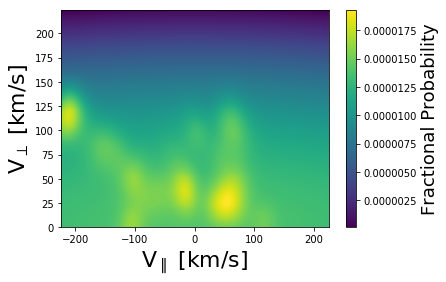

In [177]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

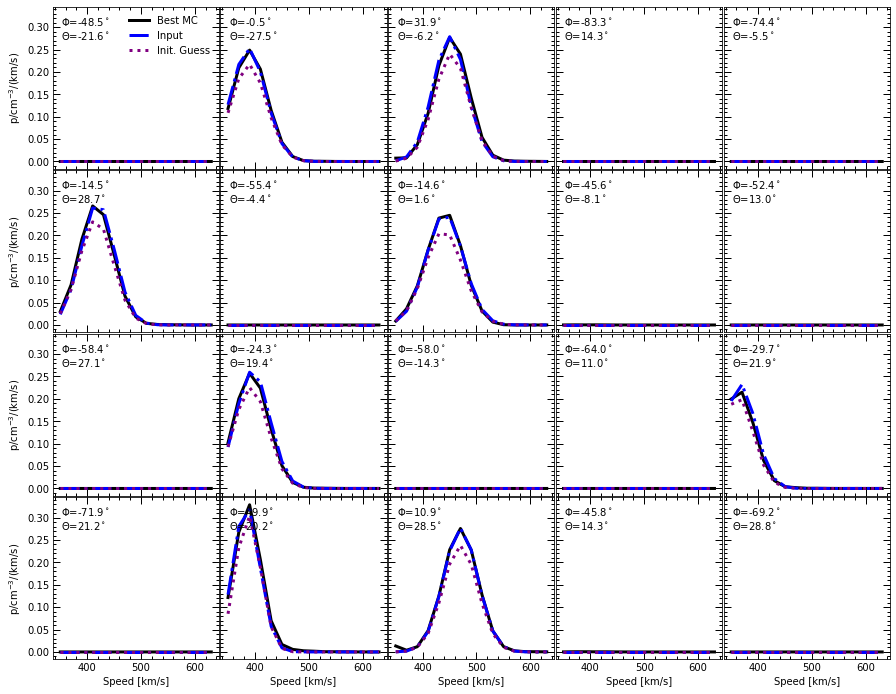

In [178]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

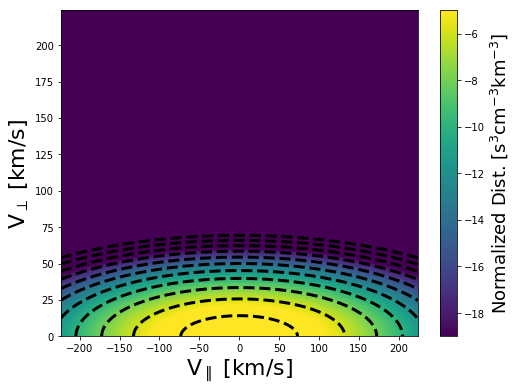

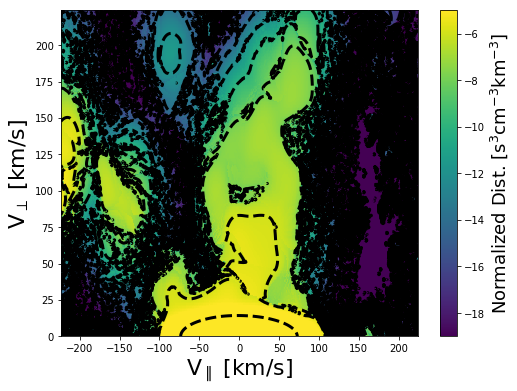

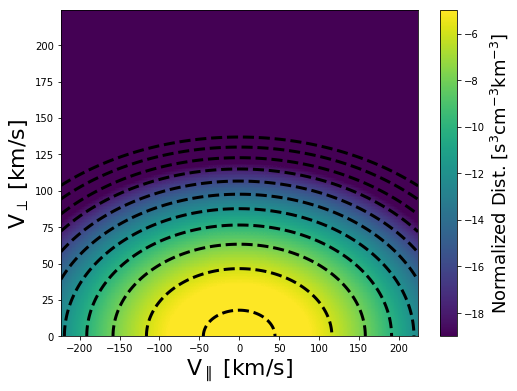

In [179]:
#Initial Guess from measurements
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()

In [163]:
reload(mdv)
reload(mff)
print(kernel)

17.6776695297


In [ ]:
scale*1000.

In [105]:
def ellipse(x,a,b):
    y = np.sqrt(b**2*(1.-(x/a)**2))
    return y
def ellipse_coords(x,y,a,b)

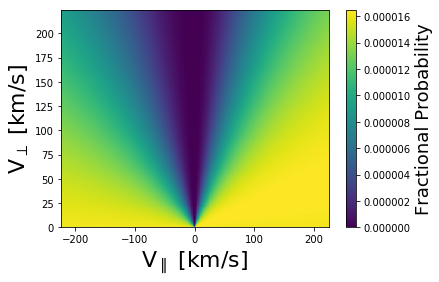

In [114]:
#Grid sampling the edge of the velocity width first
pred_grid =  np.exp(-(np.arcsinh(dis_vdf_bad_guess['qgrid']/dis_vdf_bad_guess['pgrid'])-np.arcsinh(we/wa))**2/2)
pred_grid /= np.sum(pred_grid)

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


0.196954388993


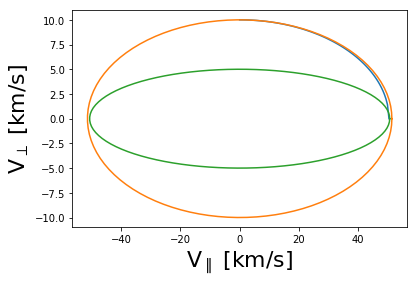

In [115]:
#Grid sampling the edge of the velocity width first
pred_grid =  np.exp(-((np.abs(dis_vdf_bad_guess['pgrid'])-wa)**2 + ((dis_vdf_bad_guess['qgrid']-we)))**2./40**2)
pred_grid /= np.sum(pred_grid)

fig, ax = plt.subplots()
x = np.linspace(0,wa,100)
y = np.sqrt(we**2*(1.-x**2/wa**2))
ax.plot(x,ellipse(x,wa,we))
nu = np.linspace(0,np.pi*2.,100)
mu = np.arcsinh(we/wa)
mu1 = np.arcsinh(0.5*we/wa)
print(mu)
ax.plot(wa*np.cosh(mu)*np.cos(nu),wa*np.sinh(mu)*np.sin(nu))
ax.plot(wa*np.cosh(mu1)*np.cos(nu),wa*np.sinh(mu1)*np.sin(nu))

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [130]:
reload(mff)

<module 'multi_fc_functions' from 'multi_fc_functions.py'>